In [121]:
import numpy as np
import pandas as pd
from collections import deque, defaultdict
import ast
import os
import glob
from pathlib import Path
from scipy.stats import mode
from modeling_parameters.config import (
    MATPLOTLIBRC_PATH,
    COORDINATES_PATH,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from modeling_parameters.reconstruction.geant.functions import(
     compute_r,
     rho_model,
     filter_clusters,
)

from functions import(
    ast_df,
    ast_modeling_df,
    is_central_stations,
)


In [200]:
events_file = '../output/events_reconstruction.csv'
kascade_folder = './KASCADE_Experiment/Ne/'


coordinates_df = pd.read_csv(COORDINATES_PATH)
X_det = np.array(coordinates_df['X'])
Y_det = np.array(coordinates_df['Y'])
Z_det = np.array(coordinates_df['Z'])



kascade1_df = pd.read_csv('../KASCADE_Experiment/Ne/43-47.csv', sep=r',\s*', engine='python')
kascade2_df = pd.read_csv('../KASCADE_Experiment/Ne/47-51.csv', sep=r',\s*', engine='python')
kascade3_df = pd.read_csv('../KASCADE_Experiment/Ne/39-43.csv', sep=r',\s*', engine='python')



events_df = pd.read_csv(events_file)
event_df = ast_df(events_df)
events_df.head(1)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
0,836,6627,63.67,116.71,33.168543,-80.0,5468.278104,1.441416,0.63366,6,6,5,0,7,"[2, 3, 4, 5, 6, 7, 8]","[False, False, False, False, True, True, False...","[0.5754942602040817, 0.22737962372448978, 0.39...","[None, None, None, None, 143.637, 88.789, None...","[None, None, None, None, 86.628, 34.227, None,...","[None, None, None, None, 2353.241, 2339.532, N..."


In [201]:
loss = np.array(events_df['loss'])
X0 = np.array(events_df['X0_opt'])
YO = np.array(events_df['Y0_opt'])
Ne = np.array(events_df['Ne_opt'])
s = np.array(events_df['s_opt'])

In [202]:
n = 2
f_events_df = events_df[events_df.apply(lambda row: is_central_stations(row, n), axis=1)]

In [308]:
f_events_df1 = f_events_df[
    (f_events_df['X0_opt'] > -20) & (f_events_df['X0_opt'] < 20) &
    (f_events_df['Y0_opt'] > -40) & (f_events_df['Y0_opt'] < 40) &
    (f_events_df['loss'] < 1) &
    (f_events_df['s_opt'] < 1.9) & (f_events_df['s_opt'] > 1.2) &
    (f_events_df['Ne_opt'] < 10 ** 5.0) & 
    (f_events_df['Ne_opt'] >  10 ** 4)
    
]

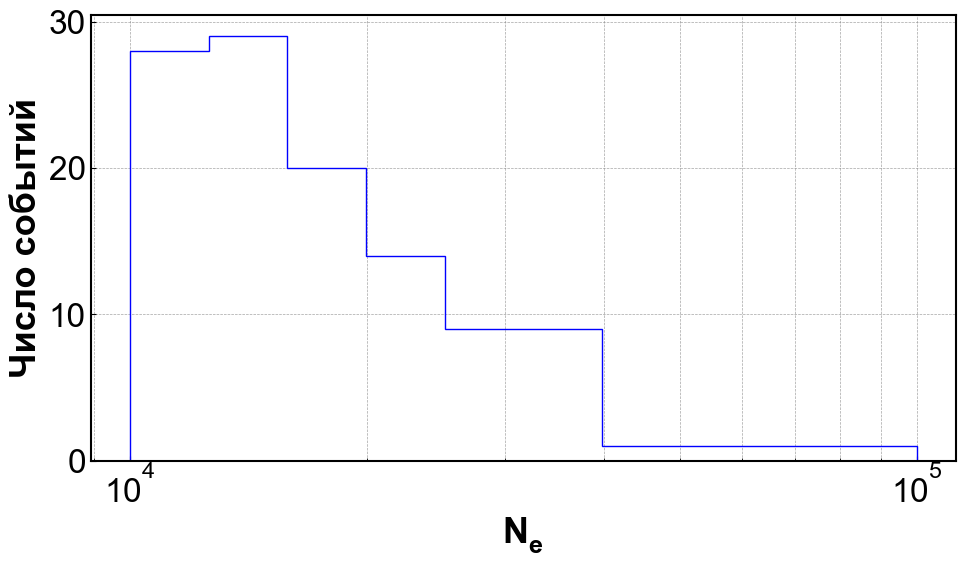

In [309]:
ne_values = f_events_df1['Ne_opt'].values

# Задаем логарифмические бин границы с шагом 0.3
log_min = np.log10(ne_values.min())
log_max = np.log10(ne_values.max())
log_bins = np.arange(log_min, log_max + 0.1, 0.1)  # шаг 0.3
bins = 10 ** log_bins  # преобразуем обратно в линейный масштаб

# Построим гистограмму
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(ne_values, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$N_e$')
plt.ylabel('Число событий')
plt.xscale('log')
plt.yscale('linear')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

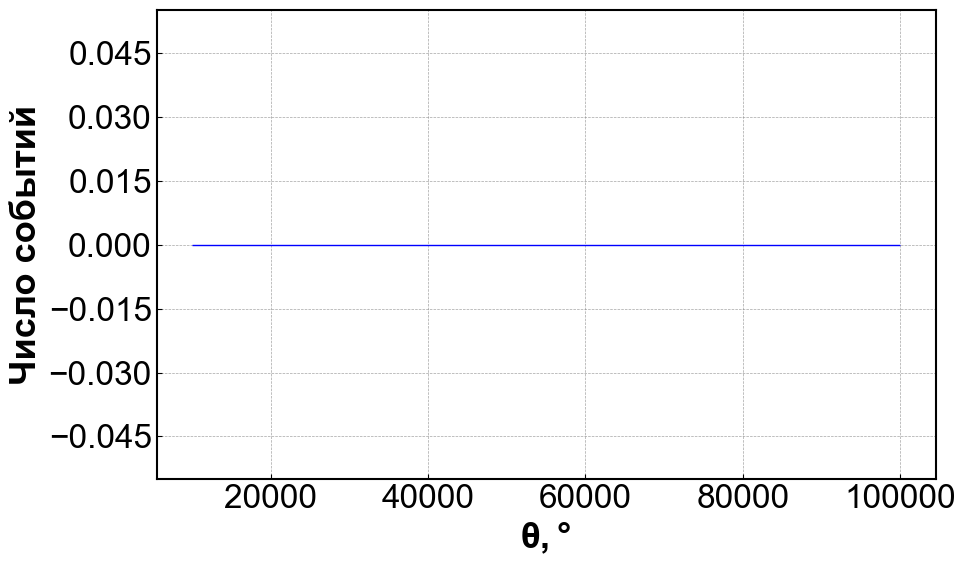

In [310]:
ne_values = f_events_df1['Theta'].values
import matplotlib.ticker as mticker
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(ne_values, bins=bins, histtype='step', color='blue')

plt.xlabel(r'$\theta, \degree$')
plt.ylabel('Число событий')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [311]:
f_events_df1.head(2)

,NRUN,NEvent,Theta,Phi,X0_opt,Y0_opt,Ne_opt,s_opt,loss,NtrackX,NtrackY,Ntrack,IdEv,Nview,worked_clusters,station_flags,rho,a_std,q_std,t_std
37,836,382082,40.02,135.32,-6.138922,24.673758,12842.777020,1.263052,0.311486,6,5,5,0,6,"[1, 2, 3, 4, 7, 8, 9]","[True, True, True, True, True, True, True, Tru...","[0.8693000637755104, 0.14813190901360543, 0.41...","[222.336, 45.291, 125.61, 213.205, 170.027, 24...","[130.854, 22.298, 62.871, 159.539, 102.379, 15...","[2348.947, 2339.103, 2351.6, 2369.482, 2352.58..."
38,836,394725,41.86,195.02,-12.352888,2.792757,12414.746474,1.607446,0.448583,5,4,4,0,5,"[1, 2, 3, 4, 5, 7, 8, 9]","[True, True, True, True, True, True, True, Tru...","[0.6225353422619048, 0.6518720769557823, 1.229...","[189.995, 133.803, 271.537, 155.008, 131.456, ...","[93.709, 98.125, 185.12, 82.022, 82.099, 62.04...","[2380.526, 2352.518, 2348.377, 2377.677, 2372...."


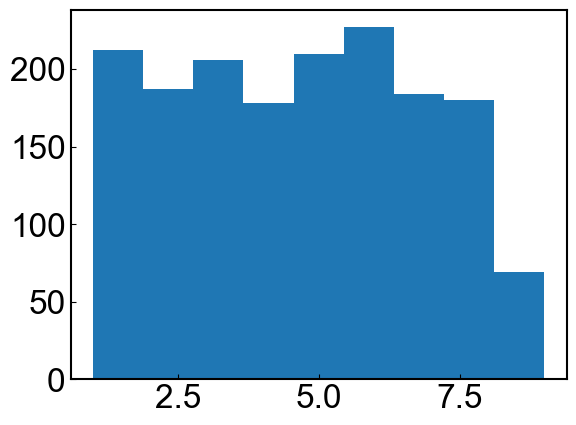

In [312]:
count = [len(cl) for cl in f_events_df['worked_clusters']]
plt.hist(count, bins=9)
plt.show()

In [313]:
Z0 = 0

row = f_events_df1.iloc[3]
nevent = row['NEvent']
nview = row['Nview']
theta = row['Theta'] 
phi = row['Phi']
rho = row['rho']
Ne = row['Ne_opt']
s = row['s_opt']


station_flags = row['station_flags']
worked_station_indices = [i for i, flag in enumerate(station_flags) if flag]

worked_coords = coordinates_df.iloc[worked_station_indices]

r = []
for _, station in worked_coords.iterrows():
    r.append(compute_r(
        float(row['X0_opt']), float(row['Y0_opt']), float(Z0),
        float(theta), float(phi),
        float(station['X']), float(station['Y']), float(station['Z'])
    )
    )

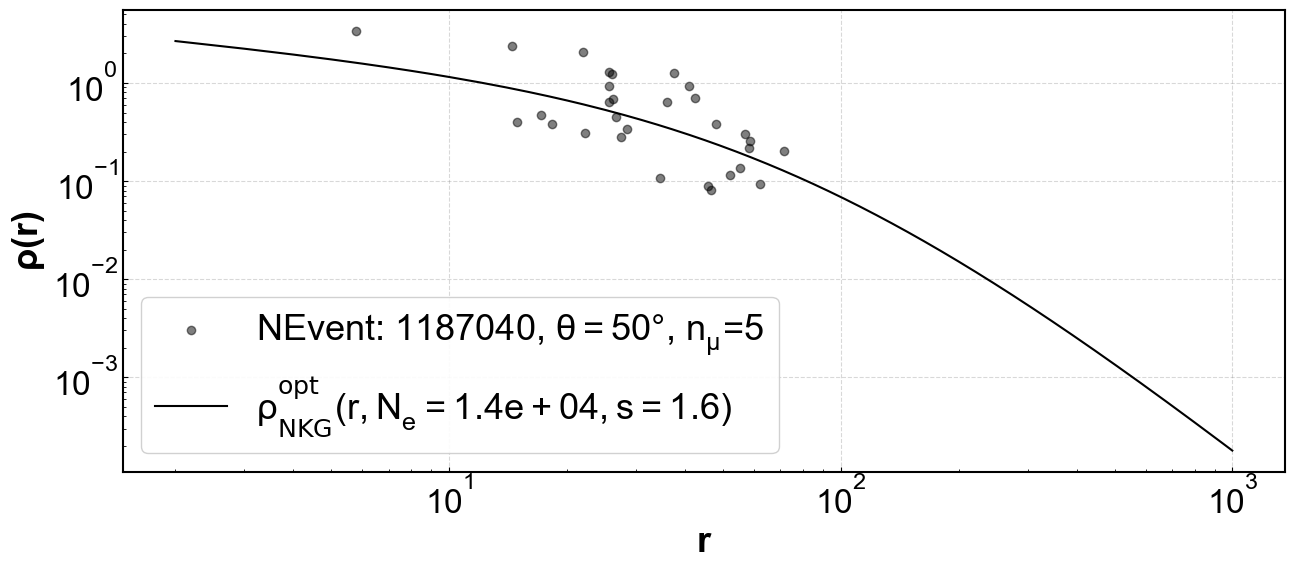

In [314]:
r_enterval= np.arange(2, 1e3, 1)
rho_calculate = rho_model(r_enterval, Ne, s)


plt.figure(figsize=(15, 6))
plt.scatter(r, rho, alpha=0.5, color='black', label=rf'NEvent: {nevent}, $\theta =${theta:.0f}$\degree$, $n_{{\mu}}$={nview}')

plt.plot(r_enterval, rho_calculate, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne:.1e}, s={s:.1f})$')


plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
# plt.savefig(f'plots/{163010}/event_{j_event}.png',
#             dpi=500, bbox_inches="tight")
plt.show()

In [315]:
Z0 = 0
all_rs, all_rs2= [], []
all_rhos, all_rhos2 = [], []
all_s, all_s2 = [], []
all_Ne, all_Ne2 = [], []

for _, row in f_events_df1.iterrows():
    theta, phi = row['Theta'], row['Phi']
    station_flags = row['station_flags']
    worked_idx = [i for i, f in enumerate(station_flags) if f]
    coords = coordinates_df.iloc[worked_idx]
    rho_vals = row['rho']
    rs = [
        compute_r(
            row['X0_opt'], row['Y0_opt'], Z0,
            theta, phi,
            float(stat['X']), float(stat['Y']), float(stat['Z'])
        )
        for _, stat in coords.iterrows()
    ]
    if len(rs) != len(rho_vals):
        continue
    all_rs.extend(rs)
    all_rhos.extend(rho_vals)
    all_s.extend([row['s_opt'] ] * len(rs))
    all_Ne.extend([row['Ne_opt']]* len(rs))
    
Ne_low = 1e4
Ne_hight = 1e5
s_val = 1.5
rho_calculate_low = rho_model(r_enterval, Ne=Ne_low, s=s_val)
rho_calculate_hight = rho_model(r_enterval, Ne=Ne_hight, s=s_val)

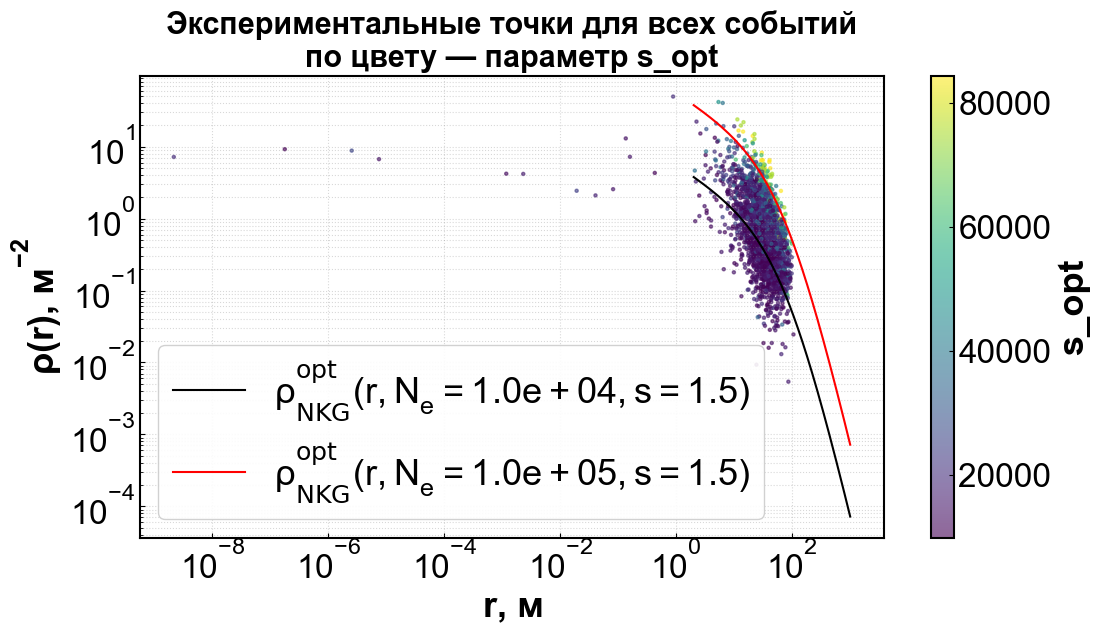

In [316]:
plt.figure(figsize=(12,6))

plt.plot(r_enterval, rho_calculate_low, c='black', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_low:.1e}, s={s_val:.1f})$')
plt.plot(r_enterval, rho_calculate_hight, c='red', 
         label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_hight:.1e}, s={s_val:.1f})$')

sc = plt.scatter(all_rs, all_rhos, c=all_Ne, cmap='viridis', s=5, alpha=0.6)
plt.xscale('log'); plt.yscale('log')
plt.colorbar(sc, label='s_opt')
plt.xlabel(r'$r$, м'); plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.title('Экспериментальные точки для всех событий\nпо цвету — параметр s_opt')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

In [317]:
r_kascade1 = kascade1_df['r']
r_kascade2 = kascade2_df['r']
r_kascade3 = kascade3_df['r']


rho_kascade1 = kascade1_df['rho']
rho_kascade2 = kascade2_df['rho']
rho_kascade3 = kascade3_df['rho']


C:\Users\matsvei\AppData\Local\Temp\ipykernel_19060\3267672334.py:16: RuntimeWarning: invalid value encountered in divide
  mean_rho = bin_sums / bin_counts
C:\Users\matsvei\AppData\Local\Temp\ipykernel_19060\3267672334.py:18: RuntimeWarning: invalid value encountered in divide
  std_rho = np.sqrt(bin_sumsq / bin_counts - mean_rho**2)


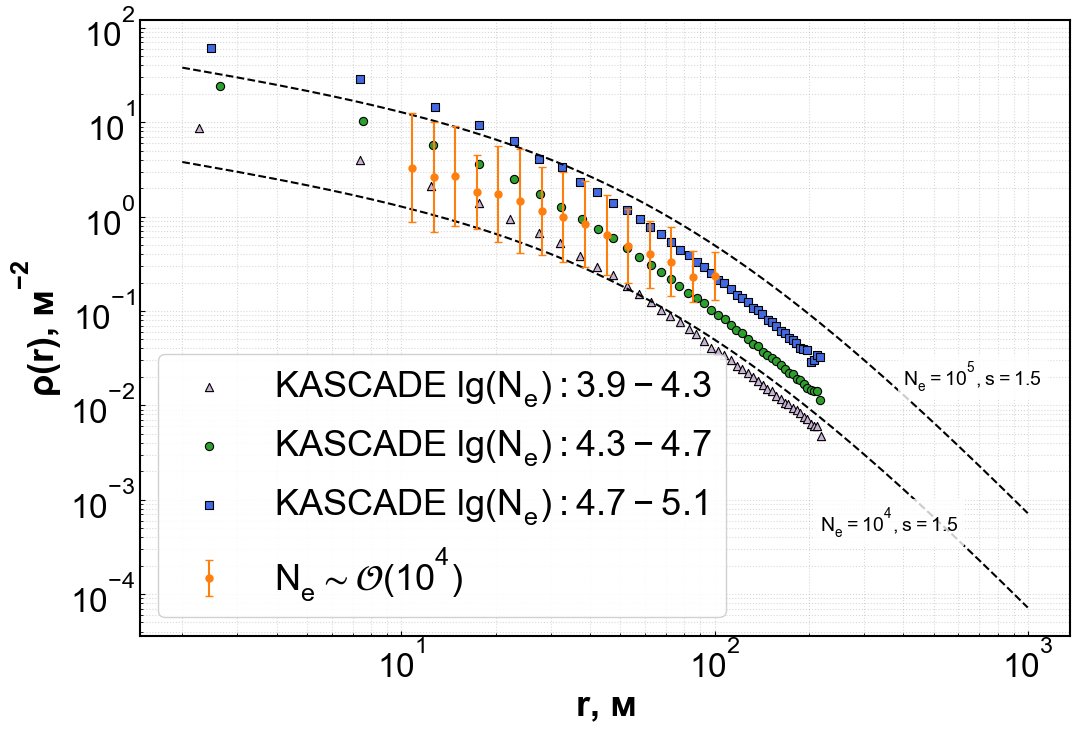

In [318]:

r_bins = np.logspace(np.log10(10), np.log10(1000), 30)
bin_centers = np.sqrt(r_bins[:-1] * r_bins[1:])

bin_sums = np.zeros(len(bin_centers))
bin_counts = np.zeros(len(bin_centers))
bin_sumsq = np.zeros(len(bin_centers))

for r_val, rho_val in zip(all_rs, all_rhos):
    idx = np.searchsorted(r_bins, r_val) - 1
    if 0 <= idx < len(bin_centers):
        bin_sums[idx] += rho_val
        bin_sumsq[idx] += rho_val**2
        bin_counts[idx] += 1

# Усреднение и стандартное отклонение
mean_rho = bin_sums / bin_counts
mean_rho = mean_rho
std_rho = np.sqrt(bin_sumsq / bin_counts - mean_rho**2)

# Пересчет ошибок для логарифмического масштаба
log_mean = np.log10(mean_rho)
log_std = std_rho / (mean_rho * np.log(10))  # Приближенно для малых отклонений

# Верхняя и нижняя границы ошибок в логарифмическом масштабе
yerr_lower = mean_rho - 10**(log_mean - log_std)
yerr_upper = 10**(log_mean + log_std) - mean_rho

yerr_lower = np.abs(yerr_lower)
yerr_upper = np.abs(yerr_upper)


# Построение графика
plt.figure(figsize=(12, 8))
# plt.plot(r_enterval, rho_calculate, c='black', 
#          label=fr'$\rho_{{\text{{NKG}}}}^{{\text{{opt}}}}(r,N_e={Ne_hight:.1e}, s={s_val:.1f})$')

line1, = plt.plot(r_enterval, rho_calculate_low, c='black', linestyle='--')
line2, = plt.plot(r_enterval, rho_calculate_hight, c='black', linestyle='--')

# Функция для умного размещения текста
def add_label(line, text, x_pos=0.5, pos='right'):
    y_pos = np.interp(x_pos, r_enterval, line.get_ydata())
    plt.text(x_pos, y_pos, text, 
             color=line.get_color(),
             ha=pos, va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             fontsize=14)

# Добавляем подписи (x_pos - положение по оси X в линейных координатах)
add_label(line1, fr'$N_e=10^{{{int(np.log10(Ne_low))}}},s=1.5$', x_pos=600, pos='right')
add_label(line2, fr'$N_e=10^{{{int(np.log10(Ne_hight))}}},s=1.5$', x_pos=400, pos='left')

plt.scatter(r_kascade3, rho_kascade3,  edgecolor='black', 
           linewidths=0.8, color='#cab2d6', alpha=1, s=35, marker='^', label=r'KASCADE $lg(N_e):3.9-4.3$')
plt.scatter(r_kascade1, rho_kascade1, edgecolor='black', 
           linewidths=0.8, color='#2ca02c', alpha=1, s=35, label=r'KASCADE $lg(N_e):4.3-4.7$')
plt.scatter(r_kascade2, rho_kascade2,  edgecolor='black', 
           linewidths=0.8, color='royalblue', alpha=1, s=35, marker='s', label=r'KASCADE $lg(N_e):4.7-5.1$')


plt.errorbar(bin_centers, mean_rho, yerr=[yerr_lower, yerr_upper], color='#ff7f0e',
             fmt='o', capsize=3, markersize=5,   label=r'$N_e \sim \mathcal{O} (10^4)$')



plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.legend()
plt.show()


## CORSIKA + GEANT

In [156]:
data_dir = '../corsika_geant/csv_output'

In [279]:
base_dir = '../../modeling_parameters/read/geant/output'
folders = ['p40', 'p50']

converters = {
    "AmplKSM": eval, "hSM": eval, "nTrackSMX": eval, "nTrackSMY": eval, "nTrackSM": eval,
    "hSM0": eval, "nTrackSMX0": eval, "nTrackSMY0": eval, "nTrackSM0": eval,
    "EdepCntSCT": eval, "EdepDetNE": eval, "TimDetNE": eval, "EdepStNE": eval, "TimStNE": eval
}

all_filtered_dfs = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filepath = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(filepath, converters=converters)
                df_filtered = df[(df['NeNKGlong'] > 1e4) & (df['NeNKGlong'] < 4e4)]
                all_filtered_dfs.append(df_filtered)
            except Exception as e:
                print(f"Ошибка в файле {file} ({folder}): {e}")

modeling_df = pd.concat(all_filtered_dfs, ignore_index=True)

# По желанию:
# final_df.to_csv("filtered_p40_p50.csv", index=False)

print(f"Всего строк после фильтрации: {len(modeling_df)}")

Всего строк после фильтрации: 578


In [280]:
modeling_df.head(1)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,hSM0,nTrackSMX0,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker
0,0.0,154000.0,1.0,14.0,1000000.0,40.0,188.16306,37.059204,-45.244747,1799544.4,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[9.274723052978516, 0.05651380121707916, 0.0...","[[[[77567.84375, 77567.8359375, 77567.7109375,...","[[9.331236839294434, 0.0, 11.676194190979004, ...","[[[77578.703125, 77567.8359375, 77567.7109375,...",-1.0


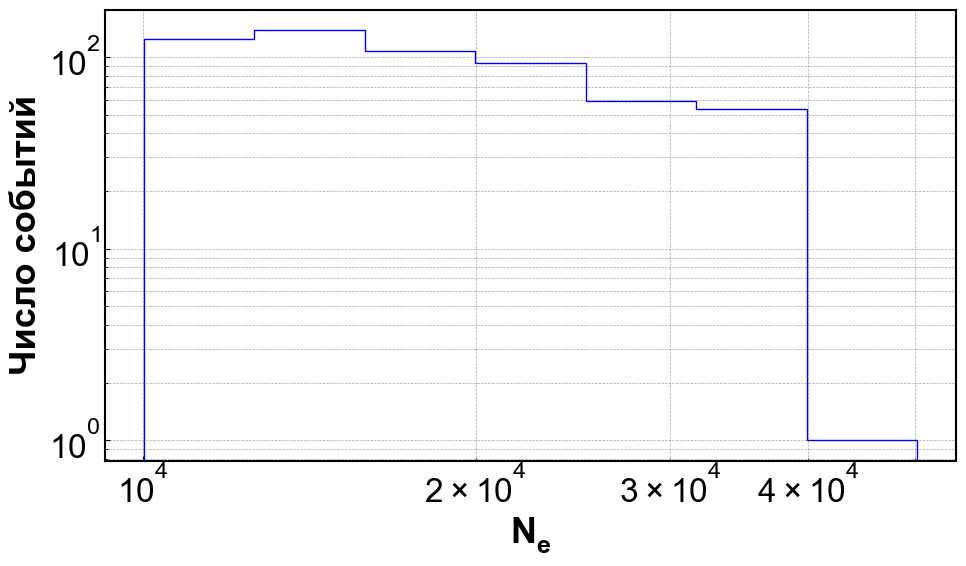

In [281]:
ne_values = modeling_df['NeNKGlong'].values


log_min = np.log10(ne_values.min())
log_max = np.log10(ne_values.max())
log_bins = np.arange(log_min, log_max + 0.1, 0.1)  # шаг 0.3
bins = 10 ** log_bins  # преобразуем обратно в линейный масштаб

# Построим гистограмму
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(ne_values, bins=bins, histtype='step', color='blue', log=True)

plt.xlabel(r'$N_e$')
plt.ylabel('Число событий')
plt.xscale('log')

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [282]:
def prepare_event(E_1_event):
    e_list = []
    for i_cluster, cluster in enumerate(E_1_event):
        for j_station, value in enumerate(cluster):
            e_list.append({'cluster': i_cluster+1, 'station': j_station+1, 'E': value})
    return pd.DataFrame(e_list)


r_modeling = []
rho_modeling = []

for j_event in range(len(modeling_df)):
    theta_g = modeling_df['Teta'].iloc[j_event]
    phi_g = modeling_df['Fi'].iloc[j_event]
    X0_g = modeling_df['XAxisShift'].iloc[j_event]
    Y0_g = modeling_df['YAxisShift'].iloc[j_event]
    Z0_g = 0
    r_geant = compute_r(
        X0_g, Y0_g, Z0_g,
        theta_g, phi_g,
        X_det, Y_det, Z_det)
    
    E_1_event = modeling_df['EdepStNE'].iloc[j_event]
    E_stations = prepare_event(E_1_event)
    worked_clusters, worked_stations, mask, rho_geant = filter_clusters(E_stations)
    
    r_modeling.append(r_geant[mask])
    rho_modeling.append(rho_geant)
    

In [283]:
all_rs_modeling = []
all_rhos_modeling = []

for j_event in range(len(r_modeling)):
    all_rs_modeling.extend(r_modeling[j_event])
    all_rhos_modeling.extend(rho_modeling[j_event])

all_rs_modeling  = np.array(all_rs_modeling )
all_rhos_modeling  = np.array(all_rhos_modeling )
len(all_rs_modeling) == len(all_rhos_modeling )

True

In [284]:
binned_rho_modeling = defaultdict(list)

    
for r, rho in zip(all_rs_modeling , all_rhos_modeling):
    bin_r = int(r // 4 * 4)  
    binned_rho_modeling[bin_r].append(rho)

binned_r_modeling = sorted(binned_rho_modeling.keys())
mean_rho_modeling  = [np.mean(binned_rho_modeling[r]) for r in binned_r_modeling]

result_modeling_df = pd.DataFrame({
    'r_bin': binned_r_modeling,
    'rho_mean':mean_rho_modeling,
    'rho_median': [np.median(binned_rho_modeling[r]) for r in binned_r_modeling],
    'rho_std': [np.std(binned_rho_modeling[r]) for r in binned_r_modeling],
    'count': [len(binned_rho_modeling[r]) for r in binned_r_modeling],      
})

result_modeling_df.head(2)

,r_bin,rho_mean,rho_median,rho_std,count
0,0,20.933501,13.850049,28.512176,91
1,4,8.342629,6.475909,6.495998,307


In [285]:
log_mean = np.log10(mean_rho_modeling)

log_std = std_rho_modeling / (mean_rho_modeling * np.log(10))

# Вычисляем верхние и нижние ошибки в линейном масштабе, соответствующие логарифмическим ошибкам
yerr_lower = mean_rho_modeling - 10**(log_mean - log_std)
yerr_upper = 10**(log_mean + log_std) - mean_rho_modeling

# Убираем отрицательные значения (на всякий случай)
yerr_lower = np.abs(yerr_lower)
yerr_upper = np.abs(yerr_upper)

# errorbar принимает yerr в формате [нижняя ошибка, верхняя ошибка]
yerr = [yerr_lower, yerr_upper]

plt.figure(figsize=(10,6))

plt.errorbar(result_modeling_df['r_bin'], 
             result_modeling_df['rho_mean'], 
             yerr=result_modeling_df['rho_std'], 
             fmt='o', 
             ecolor='gray', 
             capsize=3, 
             label='Среднее $\u03C1$ ± $\sigma$')

plt.scatter(result_modeling_df['r_bin'], 
            result_modeling_df['rho_median'], 
            color='red', 
            marker='x', 
            label='Медиана $\u03C1$')

plt.xlabel('r, м')
plt.ylabel(r'$\rho$')
plt.title('Усреднённое и медианное значение $\u03C1$ по $r$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matsvei\AppData\Local\Temp\ipykernel_19060\2135015562.py:24: SyntaxWarning: invalid escape sequence '\s'
  label='Среднее $\u03C1$ ± $\sigma$')


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

C:\Users\matsvei\AppData\Local\Temp\ipykernel_19060\1776909635.py:15: RuntimeWarning: invalid value encountered in divide
  mean_rho_mod = bin_sums_mod / bin_counts_mod
C:\Users\matsvei\AppData\Local\Temp\ipykernel_19060\1776909635.py:16: RuntimeWarning: invalid value encountered in divide
  std_rho_mod = np.sqrt(bin_sumsq_mod / bin_counts_mod - mean_rho_mod**2)


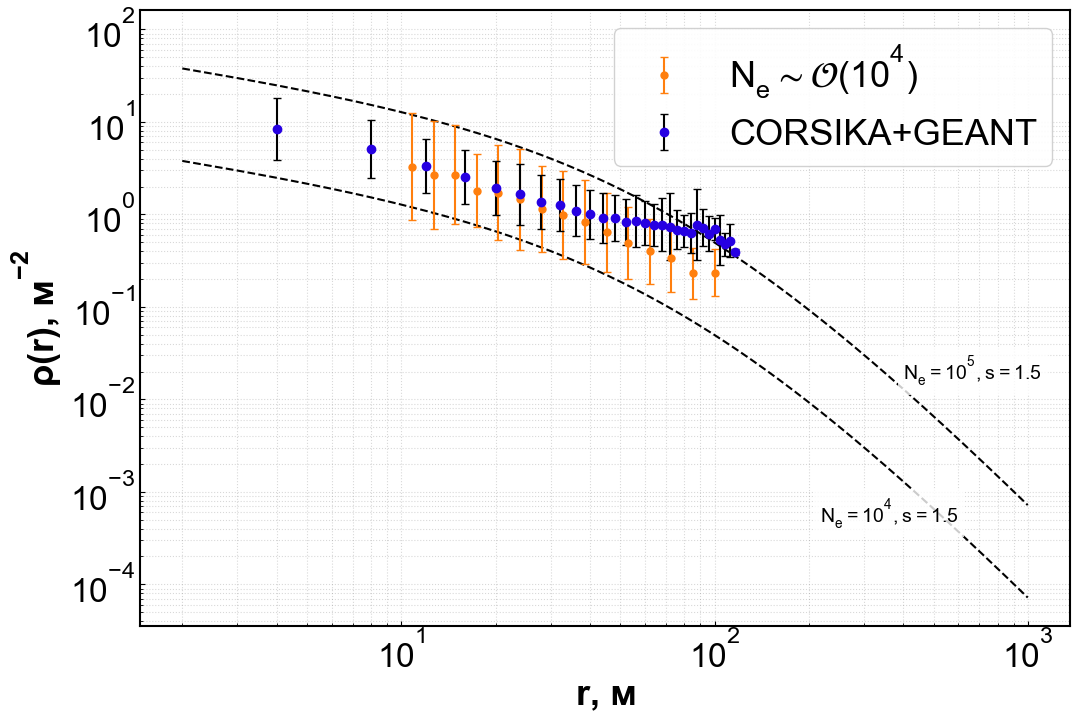

In [286]:
r_bins_mod = np.logspace(np.log10(10), np.log10(1000), 100)
bin_centers_mod = np.sqrt(r_bins_mod[:-1] * r_bins_mod[1:])

bin_sums_mod = np.zeros(len(bin_centers_mod))
bin_counts_mod = np.zeros(len(bin_centers_mod))
bin_sumsq_mod = np.zeros(len(bin_centers_mod))

for r_val, rho_val in zip(all_rs_modeling, all_rhos_modeling):
    idx = np.searchsorted(r_bins_mod, r_val) - 1
    if 0 <= idx < len(bin_centers_mod):
        bin_sums_mod[idx] += rho_val
        bin_sumsq_mod[idx] += rho_val**2
        bin_counts_mod[idx] += 1

mean_rho_mod = bin_sums_mod / bin_counts_mod
std_rho_mod = np.sqrt(bin_sumsq_mod / bin_counts_mod - mean_rho_mod**2)

log_mean_mod = np.log10(mean_rho_mod)
log_std_mod = std_rho_mod / (mean_rho_mod * np.log(10))

yerr_lower_mod = mean_rho_mod - 10**(log_mean_mod - log_std_mod)
yerr_upper_mod = 10**(log_mean_mod + log_std_mod) - mean_rho_mod

yerr_lower_mod = np.abs(yerr_lower_mod)
yerr_upper_mod = np.abs(yerr_upper_mod)

plt.figure(figsize=(12, 8))

line1, = plt.plot(r_enterval, rho_calculate_low, c='black', linestyle='--')
line2, = plt.plot(r_enterval, rho_calculate_hight, c='black', linestyle='--')

def add_label(line, text, x_pos=0.5, pos='right'):
    y_pos = np.interp(x_pos, r_enterval, line.get_ydata())
    plt.text(x_pos, y_pos, text,
             color=line.get_color(),
             ha=pos, va='bottom',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
             fontsize=14)

add_label(line1, fr'$N_e=10^{{{int(np.log10(Ne_low))}}},s=1.5$', x_pos=600, pos='right')
add_label(line2, fr'$N_e=10^{{{int(np.log10(Ne_hight))}}},s=1.5$', x_pos=400, pos='left')

# plt.errorbar(bin_centers_mod, mean_rho_mod, yerr=[yerr_lower_mod, yerr_upper_mod], color='#ff7f0e',
#              fmt='o', capsize=3, markersize=5, label=r'$Моделирование$')

# Для result_modeling_df сделаем тоже с логошибками:
mean_rho_res = result_modeling_df['rho_mean'].values
std_rho_res = result_modeling_df['rho_std'].values

log_mean_res = np.log10(mean_rho_res)
log_std_res = std_rho_res / (mean_rho_res * np.log(10))

yerr_lower_res = np.abs(mean_rho_res - 10**(log_mean_res - log_std_res))
yerr_upper_res = np.abs(10**(log_mean_res + log_std_res) - mean_rho_res)

plt.errorbar(bin_centers, mean_rho, yerr=[yerr_lower, yerr_upper], color='#ff7f0e',
             fmt='o', capsize=3, markersize=5,   label=r'$N_e \sim \mathcal{O} (10^4)$')

plt.errorbar(
    result_modeling_df['r_bin'][:-3],
    mean_rho_res[:-3],
    yerr=[yerr_lower_res[:-3], yerr_upper_res[:-3]],
    fmt='o',
    color="#2600E2",
    ecolor='black',
    capsize=3,
    label='CORSIKA+GEANT'
)


plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls=':')
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\rho(r)$, м$^{-2}$')
plt.legend()
plt.show()
